# IE6400 Project 2

# Group 1

# Task 1: Data Preprocessing

Import the dataset and perform necessary data preprocessing steps, including data cleaning, handling missing values, and converting data types if needed

In [1]:
import pandas as pd
# Load the data
df = pd.read_csv('data.csv', encoding='latin1')

# Display the first five rows of the data
print(df.head())

# Check for missing data
print("\nMissing data:")
print(df.isnull().sum())

# Impute missing values
df['Description'].fillna('Unknown', inplace=True)
df['CustomerID'] = df['CustomerID'].fillna(-1)
print(df.isnull().sum())

# Convert data types (if needed)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate']).dt.date

# Convert CustomerID to an integer
try:
    df['CustomerID'] = df['CustomerID'].astype('Int64')  # Pandas' Int64 supports NaN
except ValueError as e:
    print(f"Conversion error: {e}")

# Display the first few rows after conversion
print(df.head())

# Save the modified data back to a CSV file
#df.to_csv('/Users/kat/Downloads/data.csv', index=False)


  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom  

Missing data:
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64
InvoiceNo

# Task 2: RFM Calculation

Calculate the RFM metrics for each customer:
Recency (R): How recently a customer made a purchase. Calculate the number of days since the customer's last purchase.
Frequency (F): How often a customer makes a purchase. Calculate the total number of orders for each customer.
Monetary (M): The total monetary value of a customer's purchases. Calculate the sum of the total price for each customer.

In [2]:
import pandas as pd
import seaborn as sns
from datetime import datetime
import numpy as np


df = pd.read_csv('data_cleaned.csv', encoding='latin1')
def is_cancelled(invoice_number):
    return invoice_number[0] == "C"

# Apply the 'is_cancelled' function to create the 'IsCancelled' column
df["IsCancelled"] = df["InvoiceNo"].apply(is_cancelled)

df = df.loc[df.IsCancelled==False].copy()
df = df.drop("IsCancelled", axis=1)

df = df[df['Quantity'] >= 0]
df = df[df['UnitPrice'] >= 0]
df = df[df['CustomerID'] >= 0]

# Convert 'InvoiceDate' to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
# Find the next day after the latest date in the dataset
current_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

# Recency calculation
df_recency = df.groupby('CustomerID')['InvoiceDate'].max().reset_index()
df_recency['Recency'] = (current_date - df_recency['InvoiceDate']).dt.days

# Frequency calculation
df_frequency = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
df_frequency.rename(columns={'InvoiceNo': 'Frequency'}, inplace=True)

# Monetary calculation
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
df_monetary = df.groupby('CustomerID')['TotalPrice'].sum().reset_index()
df_monetary.rename(columns={'TotalPrice': 'Monetary'}, inplace=True)


# Task 3: RFM Segmentation

Assign RFM scores to each customer based on their quartiles (or custom-defined bins). You can use quartiles (1 to 4) or custom scores (e.g., 1 to 5) for each RFM metric.
Combine the RFM scores to create a single RFM score for each customer.

In [3]:
# Merge the RFM values
rfm = df_recency.merge(df_frequency, on='CustomerID').merge(df_monetary, on='CustomerID')
rfm.drop(columns='InvoiceDate', inplace=True)

### Standardize these values for clustering.

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])
rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=['Recency', 'Frequency', 'Monetary'])

# Task 4: Customer Segmentation

Use clustering techniques (e.g., K-Means clustering) to segment customers based on their RFM scores.
Experiment with different numbers of clusters to find the optimal number that provides meaningful segments.

In [4]:
### Apply a K-means to segment the customers based on RFM values.

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

# Determine the optimal number of clusters using the Elbow method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=0)
    kmeans.fit(rfm_scaled_df)
    wcss.append(kmeans.inertia_)

# Apply K-means clustering

# n_clusters = 3 # based on analysis
# Silhouette Score: 0.5938712415770943
# Davies-Bouldin Score: 0.7102948665797127

n_clusters = 4  # based on analysis

# n_clusters = 5  # based on analysis
# Silhouette Score: 0.6165913268227111
# Davies-Bouldin Score: 0.7166413777235827

# n_clusters = 6  # based on analysis
# Silhouette Score: 0.5982341635958884
# Davies-Bouldin Score: 0.6269038999985047

kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=0)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled_df)
rfm_scaled_df['Cluster'] = kmeans.fit_predict(rfm_scaled_df)

# 4 clusters
from sklearn.metrics import silhouette_score, davies_bouldin_score
import pandas as pd

# First, separate the features from the cluster labels
features = rfm_scaled_df[['Recency', 'Frequency', 'Monetary']]
cluster_labels = rfm_scaled_df['Cluster']

# Calculate the silhouette score
silhouette_avg = silhouette_score(features, cluster_labels)

# Calculate the Davies-Bouldin score
davies_bouldin = davies_bouldin_score(features, cluster_labels)

print(f"Silhouette Score: {silhouette_avg}")
print(f"Davies-Bouldin Score: {davies_bouldin}")

Silhouette Score: 0.6165098247715114
Davies-Bouldin Score: 0.753479078477058


# Task 5: Segment Profiling

Analyze and profile each customer segment. Describe the characteristics of customers in each segment, including their RFM scores and any other relevant attributes

In [5]:
### Analyze the characteristics of each customer segment.
cluster_summary = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CustomerID': 'count'
}).reset_index()
cluster_summary.rename(columns={'CustomerID': 'Count'}, inplace=True)
print(cluster_summary)

   Cluster     Recency  Frequency       Monetary  Count
0        0  249.173421   1.551367     478.194732   1061
1        1   44.423391   3.678210    1357.723212   3061
2        2    7.615385  82.692308  127338.313846     13
3        3   15.955882  22.333333   12709.090490    204


# Task 6: Marketing Recommendations

Provide actionable marketing recommendations for each customer segment. How can the business tailor its marketing strategies for each group to improve customer retention and maximize revenue?

## Cluster 0

Characteristics:
Moderate recency (44.47), moderate frequency (3.65), and good monetary value (1349.38). This is the second-largest group with 3054 customers.
Marketing Recommendations:
Retention Programs: Given their moderate frequency, these customers may respond well to loyalty programs that reward repeat purchases.
Targeted Communication: Use targeted email campaigns to remind them of the brand and encourage repeat visits.
Upselling: They have a good monetary value, suggesting they are open to spending more. Upselling higher-value products could be effective.


## Cluster 1

Characteristics:
Very recent (7.61), very frequent (82.69), and extremely high monetary value (127,338.31). However, this segment is very small, with only 13 customers.
Marketing Recommendations:
Exclusive Offers: Due to their high spending, offer exclusive deals or memberships to maintain their loyalty.
Personalized Service: With such a small group, highly personalized services and products can be offered.
Feedback and Co-Creation: Involve them in product development or feedback sessions, as their high engagement suggests they are likely brand advocates.

## Cluster 2

Characteristics:
Fairly recent (16.12), good frequency (22.04), and moderate monetary value (12,453.23). This group has 211 customers.
Marketing Recommendations:
Engagement Strategies: Regular engagement through newsletters, new product announcements, and events can keep the brand top-of-mind.
Referral Programs: Encourage them to refer friends to expand the customer base, leveraging their relatively recent and frequent interactions.
Community Involvement: Foster a community feeling with these customers, potentially through social media or brand clubs.

## Cluster 3

Characteristics:Least recent (249.17), least frequent (1.55), and lowest monetary value (478.19). This is the largest segment with 1061 customers.
Marketing Recommendations:
Reactivation Campaigns: Implement win-back campaigns to re-engage these customers, possibly by offering a welcome-back discount.
Survey and Incentivize: Find out why they have lapsed and offer incentives for them to provide feedback.
Product Recommendations: Send them product recommendations based on past purchases to reignite interest.

# Task 7: Visualization

Create visualizations (e.g., bar charts, scatter plots, or heat maps) to illustrate the RFM distribution and the clusters formed.

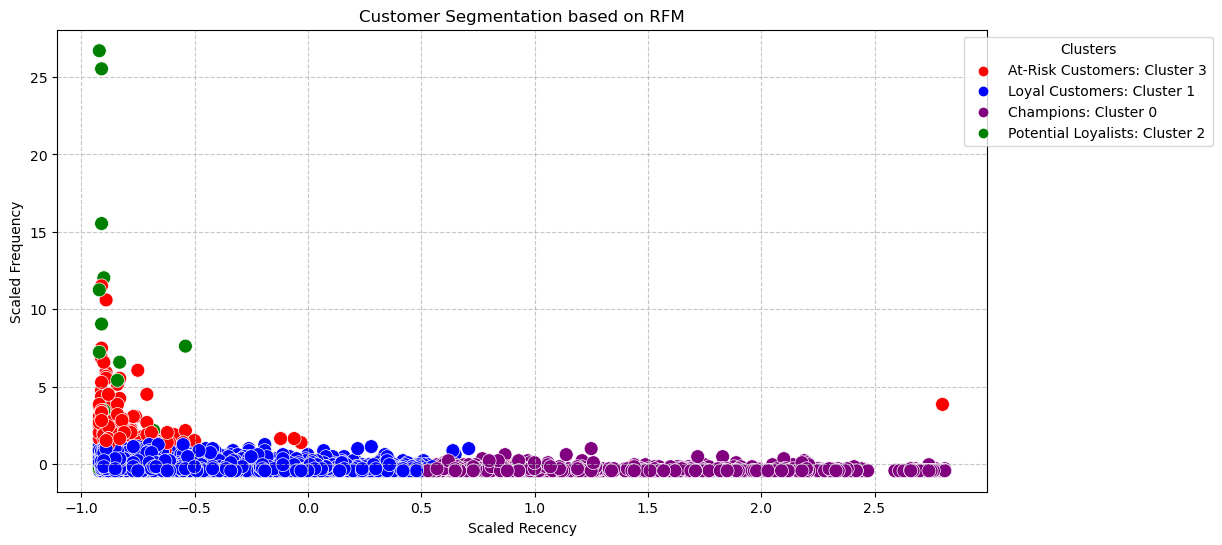

In [7]:
rfm_scaled_df['Cluster'] = rfm_scaled_df['Cluster'].replace({0: 'Champions: Cluster 0', 1: 'Loyal Customers: Cluster 1', 2: 'Potential Loyalists: Cluster 2', 3: 'At-Risk Customers: Cluster 3'})
### Visualize the distribution of customers in each segment and their RFM scores.
plt.figure(figsize=(12, 6))
# Define colors for each cluster
colors = {'Champions: Cluster 0': 'purple', 'Loyal Customers: Cluster 1': 'blue', 'Potential Loyalists: Cluster 2': 'green', 'At-Risk Customers: Cluster 3': 'red'}

# Plotting the scatter plot
sns.scatterplot(data=rfm_scaled_df, x='Recency', y='Frequency', hue='Cluster', palette=colors, s=100, linewidth=0.5, marker='o', facecolors='none')
# Adding labels and title
plt.xlabel('Scaled Recency')
plt.ylabel('Scaled Frequency')
plt.title('Customer Segmentation based on RFM')

# Adjusting legend position and labels
plt.legend(title='Clusters', loc='upper right', bbox_to_anchor=(1.25, 1))

# Adding grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.show()

# Other Analysis for Questions

# Question 1-3

In [8]:
import pandas as pd
data = pd.read_csv('data.csv', encoding='ISO-8859-1')
# Dataset size
rows, columns = data.shape

# Column descriptions
column_descriptions = data.dtypes

# Number of unique customers
unique_customers = data['CustomerID'].nunique()

# Distribution of orders per customer
orders_per_customer = data.groupby('CustomerID').size().describe()

# Top 5 customers by order count
top_5_customers = data.groupby('CustomerID').size().sort_values(ascending=False).head(5)

# Top 10 most popular products
top_10_products = data['Description'].value_counts().head(10)

# Average price of products
average_price = data['UnitPrice'].mean()

# Product category generating the highest revenue
data['TotalRevenue'] = data['Quantity'] * data['UnitPrice']
highest_revenue_product = data.groupby('Description')['TotalRevenue'].sum().sort_values(ascending=False).head(1)

print(f"Dataset Size: {rows} rows, {columns} columns")
print(f"Column Descriptions: {column_descriptions}")
print(f"Number of Unique Customers: {unique_customers}")
print(f"Distribution of Orders Per Customer: {orders_per_customer}")
print(f"Top 5 Customers by Order Count: {top_5_customers}")
print(f"Top 10 Most Popular Products: {top_10_products}")
print(f"Average Product Price: £{average_price:.2f}")
print(f"Product Category Generating the Highest Revenue: {highest_revenue_product}")

Dataset Size: 541909 rows, 8 columns
Column Descriptions: InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object
Number of Unique Customers: 4372
Distribution of Orders Per Customer: count    4372.000000
mean       93.053294
std       232.471608
min         1.000000
25%        17.000000
50%        42.000000
75%       102.000000
max      7983.000000
dtype: float64
Top 5 Customers by Order Count: CustomerID
17841.0    7983
14911.0    5903
14096.0    5128
12748.0    4642
14606.0    2782
dtype: int64
Top 10 Most Popular Products: WHITE HANGING HEART T-LIGHT HOLDER    2369
REGENCY CAKESTAND 3 TIER              2200
JUMBO BAG RED RETROSPOT               2159
PARTY BUNTING                         1727
LUNCH BAG RED RETROSPOT               1638
ASSORTED COLOUR BIRD ORNAMENT         1501
SET OF 3 CAKE TINS PANTRY DESIGN      1473
PACK OF 72 RETROSPOT CAK

# Question 4

Number of Orders by Day of the Week:
Friday        80483
Monday        93308
Sunday        63910
Thursday     101221
Tuesday       99804
Wednesday     92559
Name: Day of Week, dtype: int64

Number of Orders by Hour of the Day:
6         1
7       379
8      8805
9     33755
10    47895
11    56312
12    77230
13    71075
14    66268
15    76432
16    53451
17    27635
18     7729
19     3516
20      802
Name: Hour of Day, dtype: int64


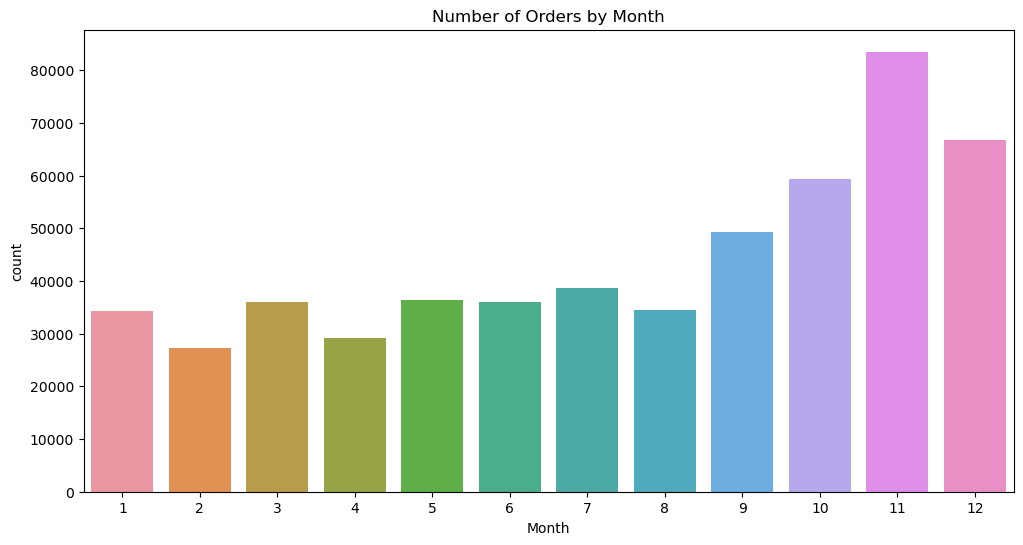

Number of Orders by Month:
1     34350
2     27184
3     35915
4     29171
5     36292
6     36056
7     38716
8     34566
9     49323
10    59396
11    83498
12    66818
Name: Month, dtype: int64
Month
1      691364.560
2      523631.890
3      717639.360
4      537808.621
5      770536.020
6      761739.900
7      719221.191
8      737014.260
9     1058590.172
10    1154979.300
11    1509496.330
12    1462538.820
Name: revenue, dtype: float64


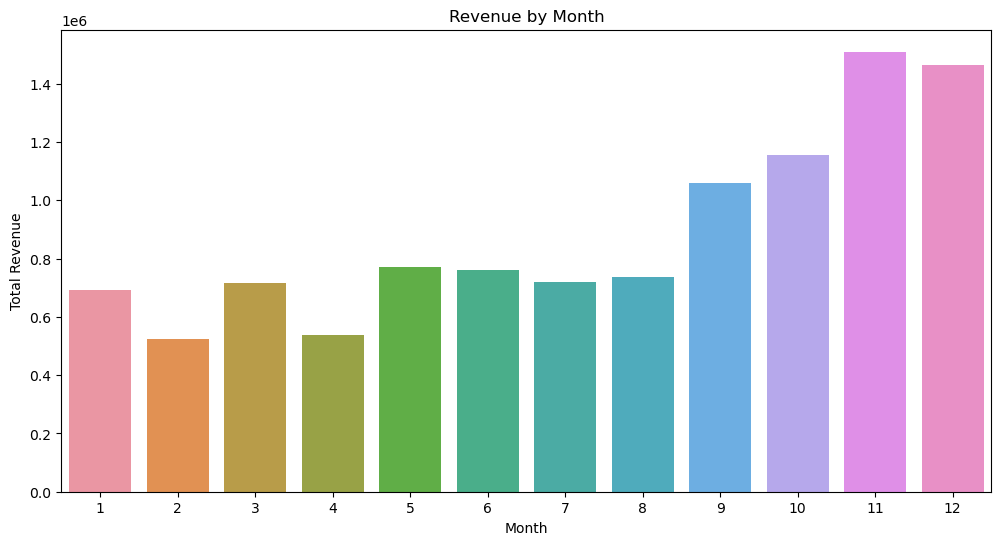

In [9]:
import pandas as pd
from datetime import datetime

data = pd.read_csv('data.csv',encoding='latin1')
df = pd.DataFrame(data)

df['Description'].fillna('Unknown', inplace=True)

df['CustomerID'] = df['CustomerID'].fillna(-1)

df['Invoice Time'] = pd.to_datetime(df['InvoiceDate']).dt.time
df['Invoice Date'] = pd.to_datetime(df['InvoiceDate']).dt.date

try:
    df['CustomerID'] = df['CustomerID'].astype('Int64')
except ValueError as e:
    print(f"convert error: {e}")

df
# check for cancelled order
def is_cancelled(invoice_number):
    return invoice_number[0] == "C"

# Apply the 'is_cancelled' function to create the 'IsCancelled' column
df["IsCancelled"] = df["InvoiceNo"].apply(is_cancelled)

# drop cancelled order
df = df.loc[df.IsCancelled==False].copy()
df = df.drop("IsCancelled", axis=1)

# Delete the rows where Quantity is less than 0
df = df[df['Quantity'] >= 0]
df
# Ensure 'Invoice Date' is in datetime format
df['Invoice Date'] = pd.to_datetime(df['Invoice Date'])

# Extract day of the week and hour of the day
df['Day of Week'] = df['Invoice Date'].dt.day_name()
df['Hour of Day'] = pd.to_datetime(df['Invoice Time'], format='%H:%M:%S').dt.hour

# Calculate the number of orders for each day of the week
orders_by_day = df['Day of Week'].value_counts().sort_index()

# Calculate the number of orders for each hour of the day
orders_by_hour = df['Hour of Day'].value_counts().sort_index()

print("Number of Orders by Day of the Week:")
print(orders_by_day)

print("\nNumber of Orders by Hour of the Day:")
print(orders_by_hour)
#seasonal trends for the number of orders
import seaborn as sns
import matplotlib.pyplot as plt
# Extract month from the 'Invoice Date'
df['Month'] = df['Invoice Date'].dt.month

#Plot the number of orders for each month
plt.figure(figsize=(12, 6))
sns.countplot(x='Month', data=df)
plt.title('Number of Orders by Month')
plt.show()
# Calculate the number of orders for each month
orders_by_month = df['Month'].value_counts().sort_index()

print("Number of Orders by Month:")
print(orders_by_month)
#seasonal trend for revenue
df['revenue']=df['Quantity']*df['UnitPrice']
monthly_revenue=df.groupby('Month')['revenue'].sum()
print(monthly_revenue)
monthly_revenue = df.groupby('Month')['revenue'].sum().reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(x='Month', y='revenue', data=monthly_revenue)
plt.title('Revenue by Month')
plt.xlabel('Month')
plt.ylabel('Total Revenue')
plt.show()

# Question 5

In [10]:
#Geographical Analysis
orders_by_country = df['Country'].value_counts()

top_countries = orders_by_country.head(5)

print("Top 5 countries with the highest number of orders:")
print(top_countries)

Top 5 countries with the highest number of orders:
United Kingdom    486286
Germany             9042
France              8408
EIRE                7894
Spain               2485
Name: Country, dtype: int64


Average Order Value by Country:
Country
Netherlands             120.798282
Australia               116.895620
Japan                   116.561900
Singapore                95.852658
Sweden                   85.096075
Hong Kong                55.252817
Denmark                  49.882474
Lithuania                47.458857
Bahrain                  41.896667
Lebanon                  37.641778
EIRE                     35.907520
Brazil                   35.737500
Norway                   33.736418
Czech Republic           33.069600
Finland                  32.913985
Greece                   32.831172
Switzerland              29.023843
United Arab Emirates     27.974706
Israel                   27.577153
Channel Islands          27.340160
Austria                  25.624824
Germany                  25.311562
France                   24.942330
Spain                    24.779521
Malta                    24.335625
Canada                   24.280662
Iceland                  23.681319
Italy          

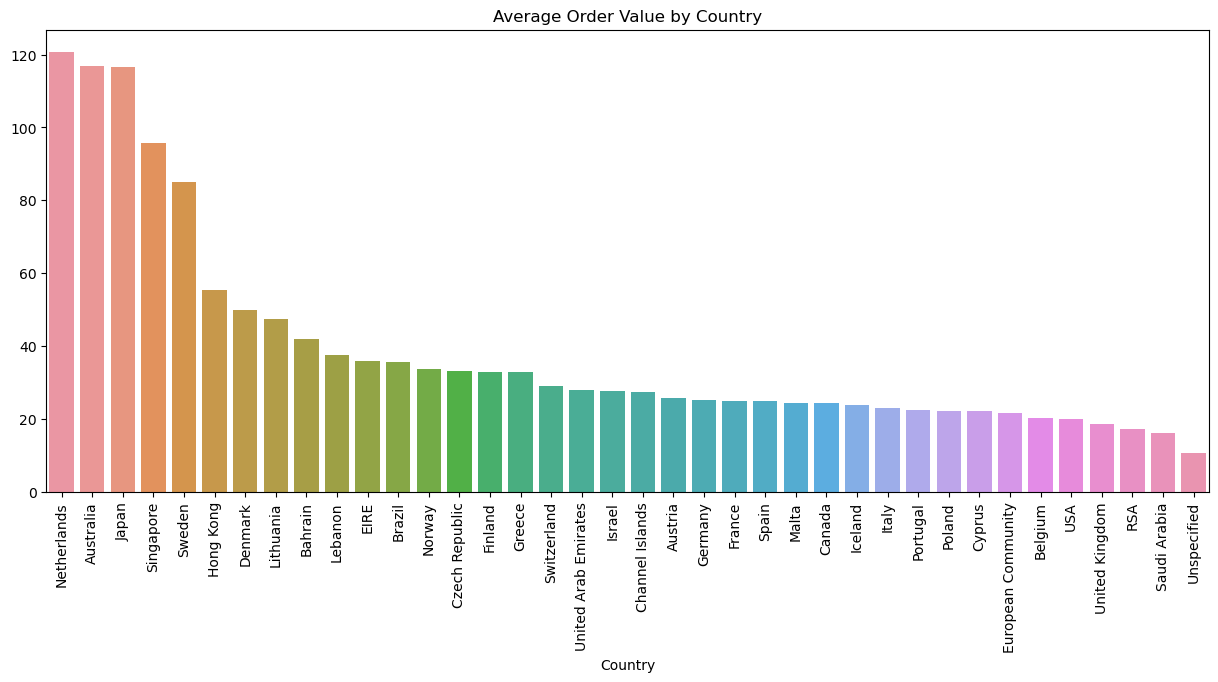

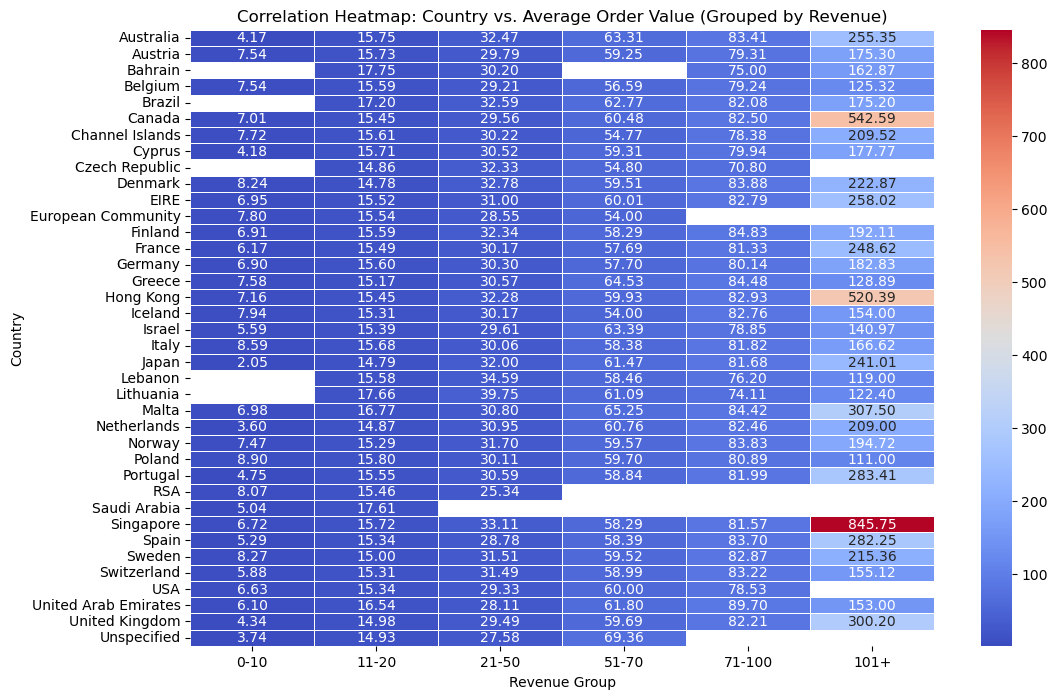

Correlation between Country and AvgOrderValue: -0.05957229675839308


In [11]:
import seaborn as sns

average_order_by_country = df.groupby('Country')['revenue'].mean().sort_values(ascending=False)

# Print results
print("Average Order Value by Country:")
print(average_order_by_country)

# Optional: Visualize the results (bar plot)
plt.figure(figsize=(15, 6))
sns.barplot(x=average_order_by_country.index, y=average_order_by_country.values)
plt.title('Average Order Value by Country')
plt.xticks(rotation=90)
plt.show()
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df['Revenue Group'] = pd.cut(df['revenue'], bins=[0, 10, 20, 50, 70, 100, float('inf')],
                             labels=['0-10', '11-20', '21-50', '51-70', '71-100', '101+'])
correlation_matrix = df.groupby(['Country', 'Revenue Group'])['revenue'].mean().unstack()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True, fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap: Country vs. Average Order Value (Grouped by Revenue)')
plt.show()
average_order_value = df.groupby('Country')['revenue']. mean().reset_index(name='AvgOrderValue')
average_order_value.head()
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
average_order_value['CountryEncoded'] = label_encoder.fit_transform(average_order_value['Country'])
correlation = average_order_value['CountryEncoded']. corr(average_order_value['AvgOrderValue'])
print(f"Correlation between Country and AvgOrderValue: {correlation}")

# Question 6

Due to incomplete of dataset in terms of payment infomation, we are not able to analysis for payment methods.

# Question 7

Average active time of customers: 130.8 days.


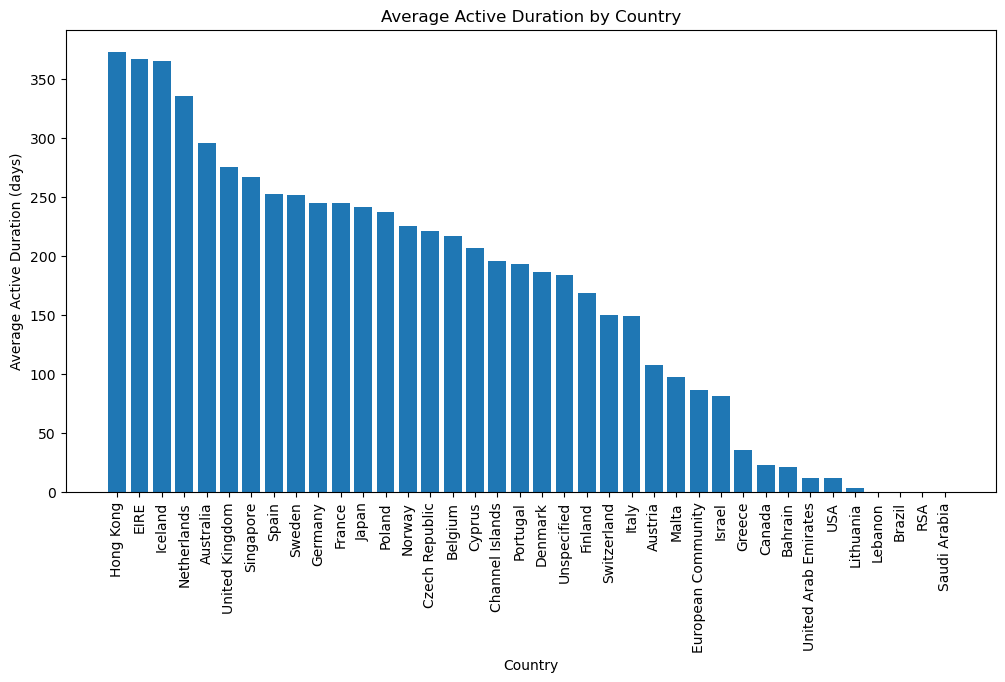

In [13]:
# Calculate the average active time of customers from every country
import pandas as pd
import matplotlib.pyplot as plt

# read the dataset
data = pd.read_csv('data_cleaned.csv', encoding='latin1')
df = pd.DataFrame(data)

df['Description'].fillna('Unknown', inplace=True)
df['CustomerID'] = df['CustomerID'].fillna(-1)
df['Invoice Time'] = pd.to_datetime(df['InvoiceDate']).dt.time
df['Invoice Date'] = pd.to_datetime(df['InvoiceDate']).dt.date
try:
    df['CustomerID'] = df['CustomerID'].astype('Int64')
except ValueError as e:
    print(f"convert error: {e}")
# check for cancelled order
def is_cancelled(invoice_number):
    return invoice_number[0] == "C"

# Apply the 'is_cancelled' function to create the 'IsCancelled' column
df["IsCancelled"] = df["InvoiceNo"].apply(is_cancelled)

df = df.loc[df.IsCancelled==False].copy()
df = df.drop("IsCancelled", axis=1)

df = df[df['Quantity'] >= 0]
df = df[df['UnitPrice'] >= 0]

# calculate the period between their first and last purchase
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
first_purchase = df.groupby('CustomerID')['InvoiceDate'].min()
last_purchase = df.groupby('CustomerID')['InvoiceDate'].max()

# calculate the active duration of every customer
active_duration = (last_purchase - first_purchase).dt.days

# calculate the mean active period
average_active_duration = round(active_duration.mean(), 2)
print(f"Average active time of customers: {average_active_duration} days.")

# Grouped by Country
customer_active_duration_by_country = df.groupby('Country')['CustomerID'].apply(
    lambda x: (last_purchase[x] - first_purchase[x]).dt.days.mean()
).reset_index(name='Average Active Duration')

# Ordered by Country
customer_active_duration_by_country = customer_active_duration_by_country.sort_values(by='Average Active Duration', ascending=False)

# Visualization
plt.figure(figsize=(12, 6))
plt.bar(customer_active_duration_by_country['Country'], customer_active_duration_by_country['Average Active Duration'])
plt.xlabel('Country')
plt.ylabel('Average Active Duration (days)')
plt.title('Average Active Duration by Country')
plt.xticks(rotation=90)
plt.show()

# Question 8

In [16]:
# 8.Returns and Refunds -- gsy
# Percentage of orders with returns or refunds
import pandas as pd

# read the dataset
data = pd.read_csv('data_cleaned.csv')
df = pd.DataFrame(data)

# Count orders with returns or refunds
returned_orders = df[df['Quantity'] < 0]['InvoiceNo'].nunique()

# Count the total number of orders
total_orders = df['InvoiceNo'].nunique()

# Count the percentage
return_percentage = (returned_orders / total_orders) * 100
print(f"Percentage of orders with returns or refunds:{return_percentage:.2f}%")

# Find return
df['Returned'] = df['Quantity'] < 0

# Calculate the return quantity of countries
return_rates_by_country = df.groupby('Country')['Returned'].mean()

# Print the result
print(return_rates_by_country)

Percentage of orders with returns or refunds:19.97%
Country
Australia               0.058777
Austria                 0.007481
Bahrain                 0.052632
Belgium                 0.018366
Brazil                  0.000000
Canada                  0.000000
Channel Islands         0.013193
Cyprus                  0.012862
Czech Republic          0.166667
Denmark                 0.023136
EIRE                    0.036847
European Community      0.016393
Finland                 0.014388
France                  0.017413
Germany                 0.047709
Greece                  0.006849
Hong Kong               0.013889
Iceland                 0.000000
Israel                  0.006734
Italy                   0.056040
Japan                   0.103352
Lebanon                 0.000000
Lithuania               0.000000
Malta                   0.118110
Netherlands             0.003374
Norway                  0.012891
Poland                  0.032258
Portugal                0.011850
RSA             

# Question 9

False    98.286059
True      1.713941
Name: IsCancelled, dtype: float64
Number of rows with Quantity less than 0: 1336
Total Profit: $1098344.90
StockCode
DOT       35903.2340
22423     17448.4740
23843     16846.9600
M         14585.5825
85123A    10451.8800
47566      9950.4330
85099B     9434.0050
22502      9104.6120
POST       8949.5570
23166      8170.0920
Name: TotalProfit, dtype: float64


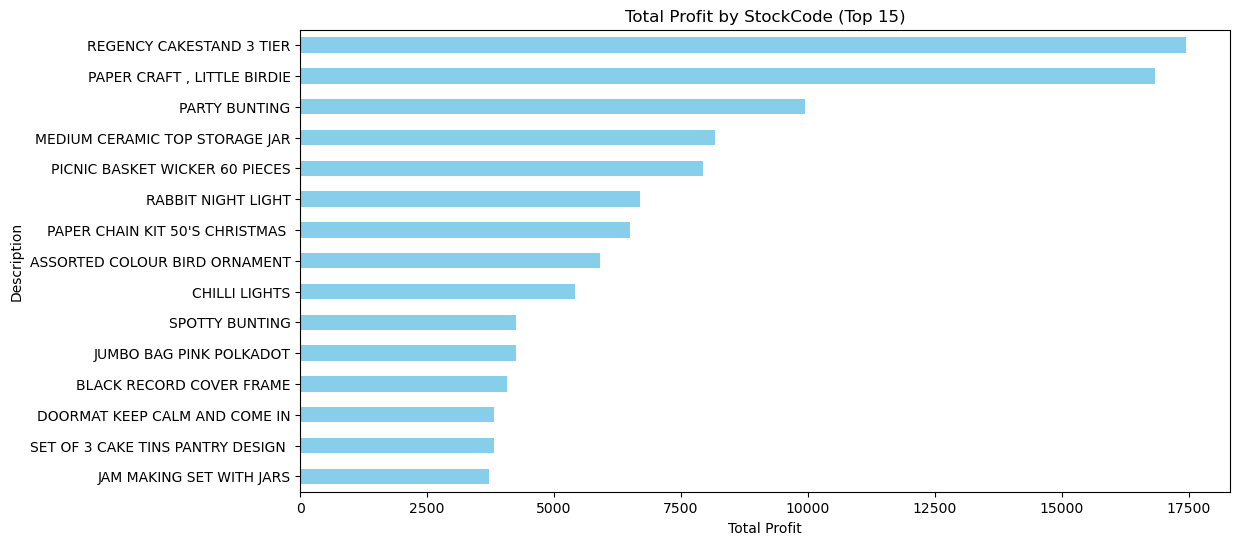

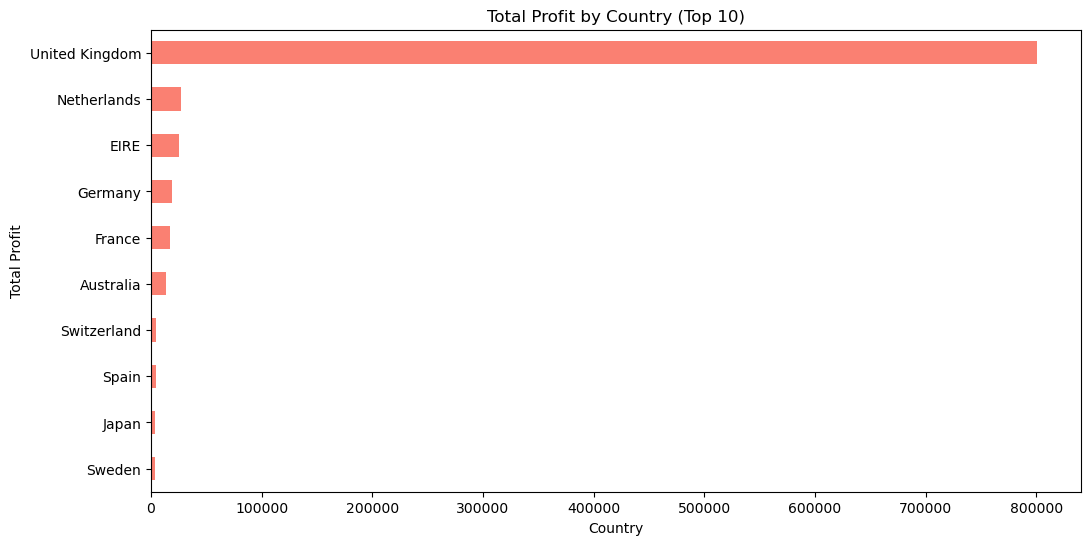

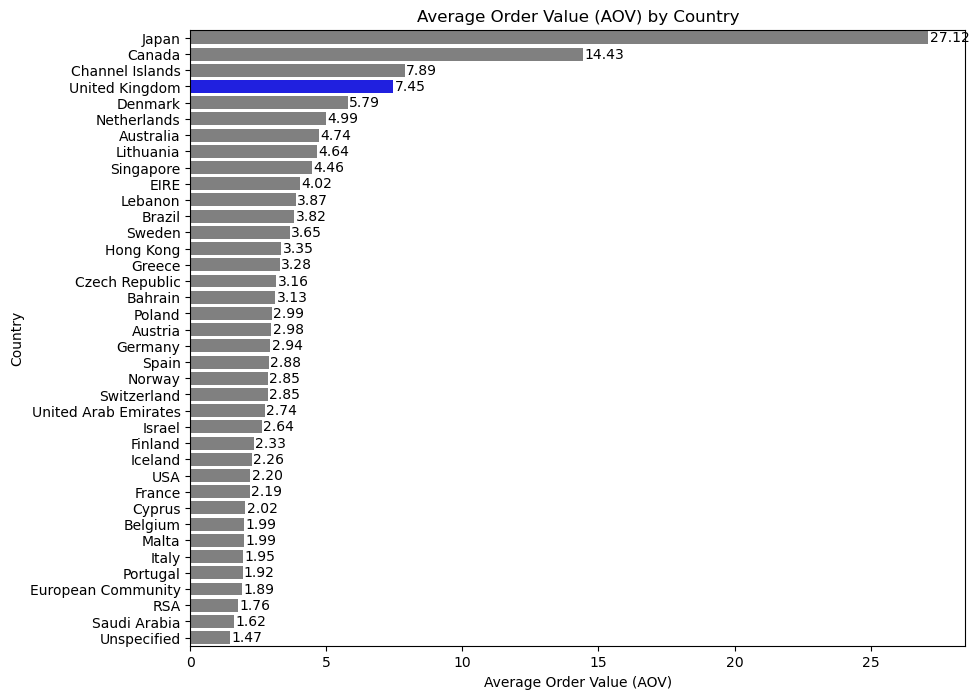

CustomerID
12346    7718.360000
16446    5615.750000
15098    2651.200000
15749     482.263333
15195     386.100000
18087     320.292000
13135     309.600000
16532     168.720000
16000     137.707778
16754     100.120000
Name: TotalProfit, dtype: float64


In [17]:
import pandas as pd
import seaborn as sns
from datetime import datetime
import numpy as np


df = pd.read_csv('data.csv', encoding='latin1')
df['Description'].fillna('Unknown', inplace=True)
df['CustomerID'] = df['CustomerID'].fillna(-1)
df['Invoice Time'] = pd.to_datetime(df['InvoiceDate']).dt.time
df['Invoice Date'] = pd.to_datetime(df['InvoiceDate']).dt.date
try:
    df['CustomerID'] = df['CustomerID'].astype('Int64')
except ValueError as e:
    print(f"convert error: {e}")


def is_cancelled(invoice_number):
    return invoice_number[0] == "C"

# Apply the 'is_cancelled' function to create the 'IsCancelled' column
df["IsCancelled"] = df["InvoiceNo"].apply(is_cancelled)

# Calculate the percentage of canceled and non-canceled transactions
cancelled_percentage = df["IsCancelled"].value_counts(normalize=True) * 100
print(cancelled_percentage)

# drop cancelled order
df = df.loc[df.IsCancelled==False].copy()
df = df.drop("IsCancelled", axis=1)

# check for returned order (Quantity less than 0)
negative_quantity_count = df[df['Quantity'] < 0].shape[0]
print(f"Number of rows with Quantity less than 0: {negative_quantity_count}")
# Delete the rows where Quantity is less than 0
df = df[df['Quantity'] >= 0]
df = df[df['UnitPrice'] >= 0]

# Calculate total profit generated by the company
df['Profit'] = np.where(df['UnitPrice'] < 0, 0,
                          np.where(df['UnitPrice'] < 50, 0.1 * df['UnitPrice'],
                                   np.where(df['UnitPrice'] < 500, 0.15 * df['UnitPrice'],
                                            0.2 * df['UnitPrice'])))
df['TotalProfit'] = df['Quantity'] * df['Profit']
total_profit = df['TotalProfit'].sum()

# Display total profit
print(f"Total Profit: ${total_profit:.2f}")

import matplotlib.pyplot as plt

# 1. Bar chart of total profit by StockCode
total_profit_by_stockcode = df.groupby('StockCode')['TotalProfit'].sum().sort_values(ascending=False)
print(total_profit_by_stockcode.head(10))

df["nNumericStockCode"] = df['StockCode'].apply(lambda x: sum(c.isdigit() for c in x))

# Create 'StockCodeLength' column
df["StockCodeLength"] = df['StockCode'].apply(len)
# Filter rows based on conditions
df_profit = df[(df["nNumericStockCode"] == 5) & (df["StockCodeLength"] == 5)].copy()
df_profit = df_profit[["StockCode", "Description", "CustomerID", "Country", "TotalProfit"]]

total_profit_by_profit = df_profit.groupby('Description')['TotalProfit'].sum().sort_values(ascending=True)

plt.figure(figsize=(12, 6))
total_profit_by_profit.tail(15).plot(kind='barh', color='skyblue')
plt.title('Total Profit by StockCode (Top 15)')
plt.xlabel('Total Profit')
plt.ylabel('Description')
plt.show()

# 2. Bar chart of total profit by Country
total_profit_by_country = df_profit.groupby('Country')['TotalProfit'].sum().sort_values(ascending=True)

plt.figure(figsize=(12, 6))
total_profit_by_country.tail(10).plot(kind='barh', color='salmon')
plt.title('Total Profit by Country (Top 10)')
plt.xlabel('Country')
plt.ylabel('Total Profit')
plt.show()

# Aggregate Total Profit by CustomerID and Country
total_profit_by_customer_country = df_profit.groupby(['CustomerID', 'Country'])['TotalProfit'].sum().reset_index()

# Count Total Orders by CustomerID and Country
total_orders_by_customer_country = df_profit.groupby(['CustomerID', 'Country']).size().reset_index(name='TotalOrders')

# Merge the two DataFrames
merged_df = pd.merge(total_profit_by_customer_country, total_orders_by_customer_country, on=['CustomerID', 'Country'])

# Calculate AOV (Average Order Value)
merged_df['AOV'] = merged_df['TotalProfit'] / merged_df['TotalOrders']

# Calculate Average AOV for each country
average_aov_by_country = merged_df.groupby('Country')['AOV'].mean().reset_index()

# Sort the DataFrame by AOV in descending order
average_aov_by_country = average_aov_by_country.sort_values(by='AOV', ascending=False)

# Plot the results
plt.figure(figsize=(10, 8))
palette = ['blue' if country == 'United Kingdom' else 'gray' for country in average_aov_by_country['Country']]
ax = sns.barplot(x='AOV', y='Country', data=average_aov_by_country, palette=palette)
plt.title('Average Order Value (AOV) by Country')
plt.xlabel('Average Order Value (AOV)')
plt.ylabel('Country')

# Annotate AOV values
for i, value in enumerate(average_aov_by_country['AOV']):
    ax.text(value + 0.05, i, f'{value:.2f}', va='center', color='black')

plt.show()

# 3. mean profit by CustomerID (Top 50 with the highest profit margins)
top_10_customers = df_profit.groupby('CustomerID')['TotalProfit'].mean().sort_values(ascending=False).head(10)
print(top_10_customers)

# Question 10

Percentage of non-canceled returned orders: 0.25%


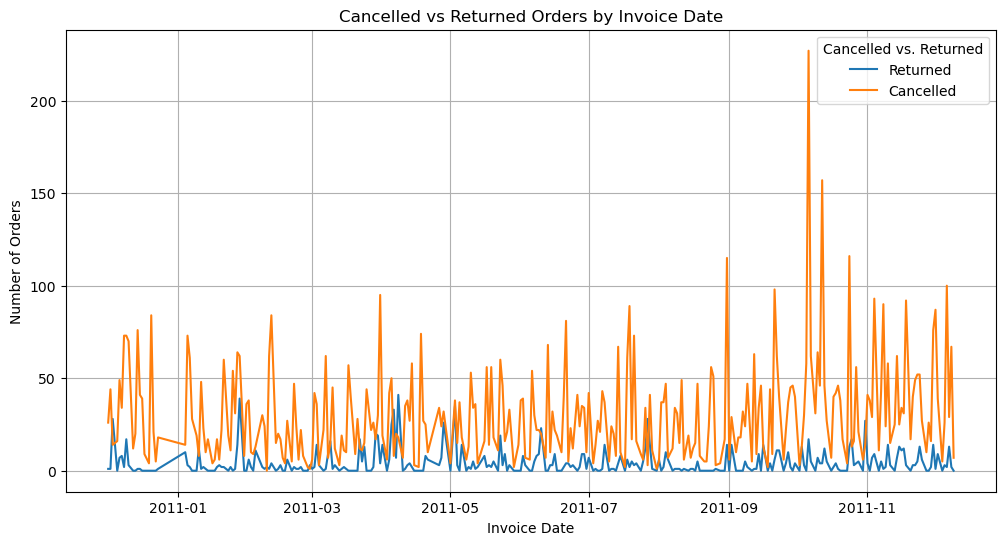

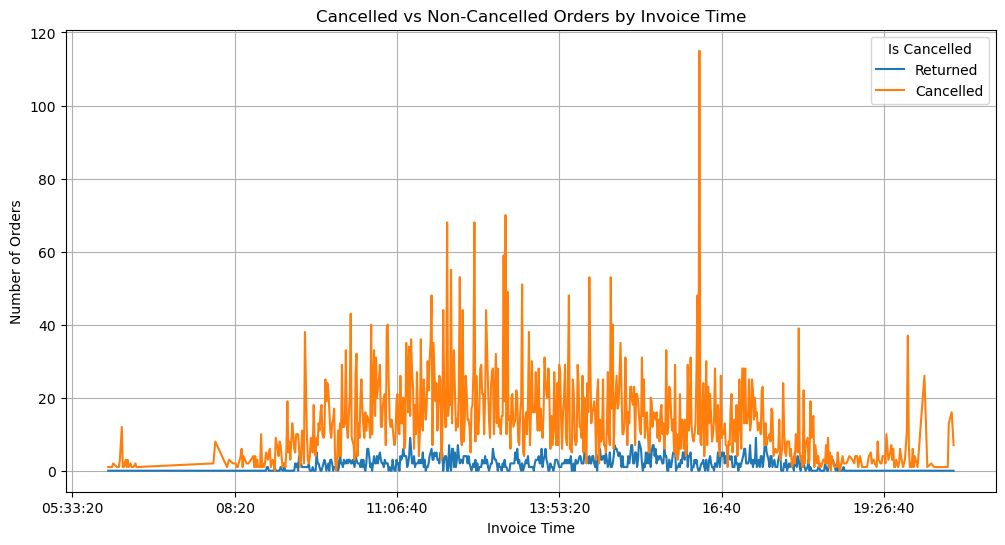

In [18]:
df_cus = pd.read_csv('data.csv', encoding='latin1')
df_cus['Description'].fillna('Unknown', inplace=True)
df_cus['CustomerID'] = df_cus['CustomerID'].fillna(-1)
df_cus['Invoice Time'] = pd.to_datetime(df_cus['InvoiceDate']).dt.time
df_cus['Invoice Date'] = pd.to_datetime(df_cus['InvoiceDate']).dt.date
try:
    df_cus['CustomerID'] = df_cus['CustomerID'].astype('Int64')
except ValueError as e:
    print(f"convert error: {e}")

# chose Quantity < 0, means returned orders
df_return = df_cus[df_cus['Quantity'] < 0]
df_return_inv = df_return.groupby('InvoiceNo')['Description'].count()

def is_cancelled(invoice_number):
    return invoice_number[0] == "C"

# Apply the 'is_cancelled' function to create the 'IsCancelled' column
df_return["IsCancelled"] = df_return["InvoiceNo"].apply(is_cancelled)

# Calculate the percentage of canceled and non-canceled transactions
cancelled_percent = df_return["IsCancelled"].value_counts(normalize=True) * 100
non_cancelled_count = df_return["IsCancelled"].value_counts().get(False, 0)

# Calculate the percentage of non-canceled orders among all orders
percentage_non_cancelled = (non_cancelled_count / len(df)) * 100

print(f"Percentage of non-canceled returned orders: {percentage_non_cancelled:.2f}%")


# Convert Invoice Date and Time to datetime

# Grouping by Invoice Date and counting IsCancelled
date_grouped = df_return.groupby(['Invoice Date', 'IsCancelled']).size().unstack(fill_value=0)
date_grouped.rename(columns={True: 'Cancelled', False: 'Returned'}, inplace=True)

# Plotting count of cancelled vs non-cancelled orders by Invoice Date
plt.figure(figsize=(12, 6))
date_grouped.plot(kind='line', ax=plt.gca())
plt.title('Cancelled vs Returned Orders by Invoice Date')
plt.xlabel('Invoice Date')
plt.ylabel('Number of Orders')
plt.grid(True)
plt.legend(title='Cancelled vs. Returned')
plt.show()

# Grouping by Invoice Time and counting IsCancelled
time_grouped = df_return.groupby(['Invoice Time', 'IsCancelled']).size().unstack(fill_value=0)
time_grouped.rename(columns={True: 'Cancelled', False: 'Returned'}, inplace=True)

# Plotting count of cancelled vs non-cancelled orders by Invoice Time
plt.figure(figsize=(12, 6))
time_grouped.plot(kind='line', ax=plt.gca())
plt.title('Cancelled vs Non-Cancelled Orders by Invoice Time')
plt.xlabel('Invoice Time')
plt.ylabel('Number of Orders')
plt.grid(True)
plt.legend(title='Is Cancelled')
plt.show()